In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
from tqdm.notebook import tqdm
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


sys.path.insert(0, '..')

import dataset.preprocessing as utils
from config import *

In [3]:
emb_dir = os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings')
all_files_name = os.listdir(os.path.join(emb_dir, '32'))
all_files = list(pd.Series(all_files_name).str.extractall('(.*)\.npy').reset_index()[0])

In [4]:
df = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))

In [5]:
df_posneg = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_posneg.csv'))
df_posneg = df_posneg.sample(frac = 1).reset_index(drop = True)

In [6]:
df = df[df.id_query.isin(all_files)].reset_index(drop = True)
df_posneg = df_posneg[df_posneg.id_query.isin(all_files)].reset_index(drop = True)

In [7]:
def load_features(arrays_to_load):
    # Initialize an empty list to store the loaded arrays
    loaded_arrays = []

    # Loop through each file and load the numpy array
    for file_name in tqdm(arrays_to_load):
        # Load the numpy array from file
        array_data = np.load(os.path.join(emb_dir, '32', file_name + '.npy'))

        # Append the loaded array to the list
        loaded_arrays.append(array_data)

    # Stack the loaded arrays along the first axis to create a single array
    result_array = np.stack(loaded_arrays)

    # Verify the shape of the resulting array
    print("Shape of the resulting array:", result_array.shape)
    
    return result_array

In [80]:
posneg_features = load_features(list(df_posneg.id_query))

df_features = load_features(list(df.id_query))

  0%|          | 0/87194 [00:00<?, ?it/s]

Shape of the resulting array: (87194, 2560)


  0%|          | 0/119123 [00:00<?, ?it/s]

Shape of the resulting array: (119123, 2560)


# PCA

In [9]:
plt.rcParams['figure.figsize'] = [8, 6]

In [10]:
scaler = StandardScaler()
pca = PCA(n_components=2)

In [11]:
def create_pca(features):
    numerical_features_scaled = scaler.fit_transform(features)
    pca_result = pca.fit_transform(numerical_features_scaled)
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    return pca_df, pca

In [12]:
pca_df_posneg, pca_posneg = create_pca(posneg_features)

final_df_posneg = pd.concat([pca_df_posneg, df_posneg], axis=1) 

In [13]:
pca_df_features, pca_features = create_pca(df_features)

repeats_df = pd.concat([pca_df_features, df], axis = 1)

### Results positive / negative

In [14]:
len(df_posneg['gene_id'].unique())

43852

subset:  paris


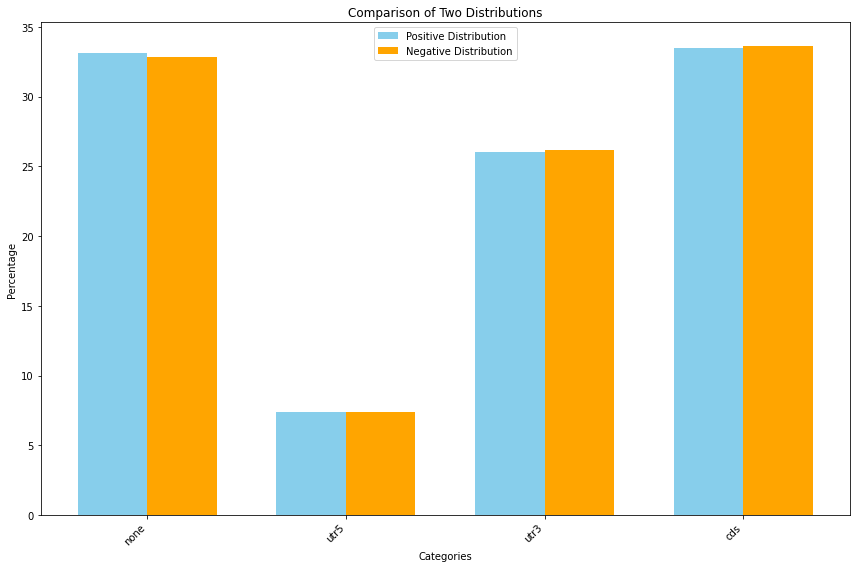

subset:  splash


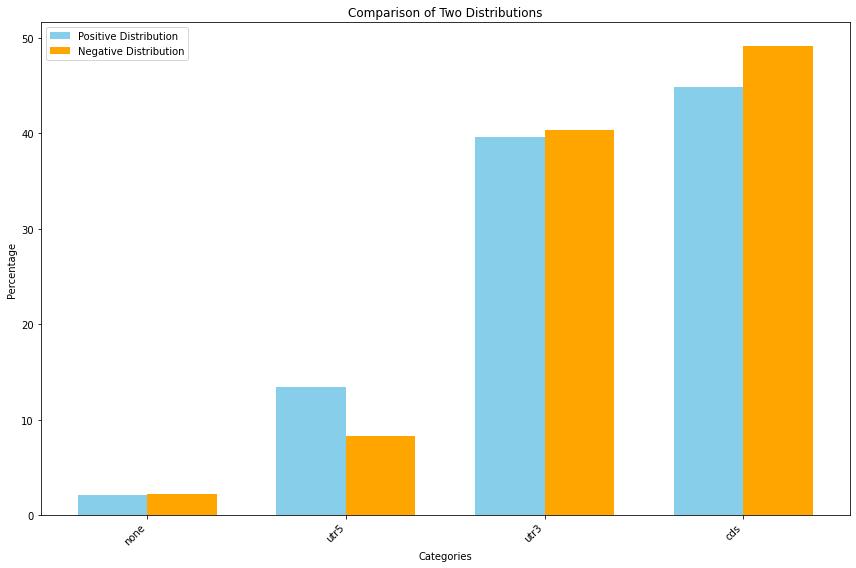

subset:  ricseq


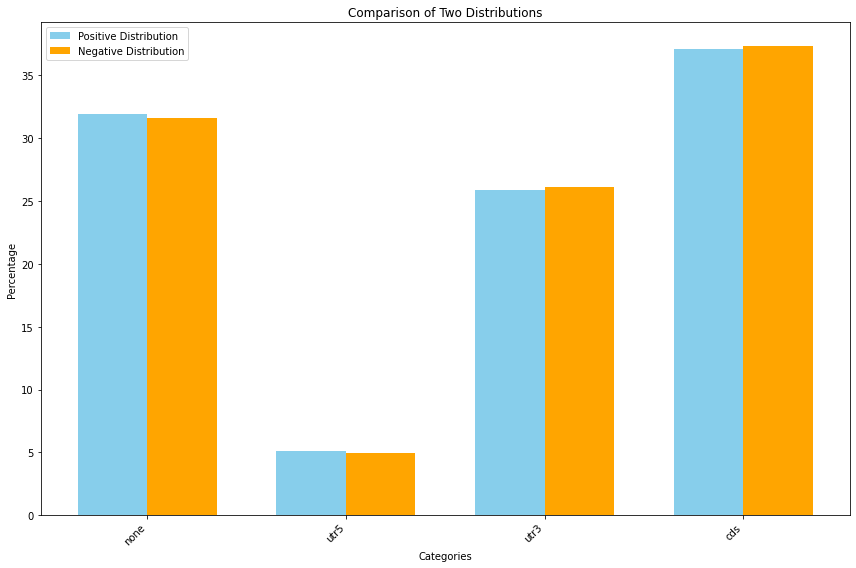

In [15]:
def plot_interaction_region(df):
    df_int, df_neg = df[df.interacting == True], df[df.interacting == False]
    
    # PLOT 
    categories = list(set(df_int['where'].value_counts().index).union(df_neg['where'].value_counts().index))

    neg = df_neg['where'].value_counts()
    neg = pd.Series([neg.get(key, 0) for key in categories], index=categories)

    pos = df_int['where'].value_counts()
    pos = pd.Series([pos.get(key, 0) for key in categories], index=categories)

    values1 = pos.values

    values2 = neg.values

    total1 = sum(values1)
    total2 = sum(values2)

    percentages1 = np.array([value / total1 * 100 for value in values1])
    percentages2 = np.array([value / total2 * 100 for value in values2])

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots(figsize=(12, 8))
    bar1 = ax.bar(index, percentages1, bar_width, label='Positive Distribution', color='skyblue')
    bar2 = ax.bar(index + bar_width, percentages2, bar_width, label='Negative Distribution', color='orange')

    ax.set_xlabel('Categories')
    ax.set_ylabel('Percentage')
    ax.set_title('Comparison of Two Distributions')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()
    
df_posneg['interacting'] = False
df_posneg.loc[ df_posneg['how'] == 'positive', 'interacting'] = True

for subset in ['paris', 'splash', 'ricseq']:
    print('subset: ', subset)
    df_subset = df_posneg[df_posneg.dataset == subset]
    plot_interaction_region(df_subset)

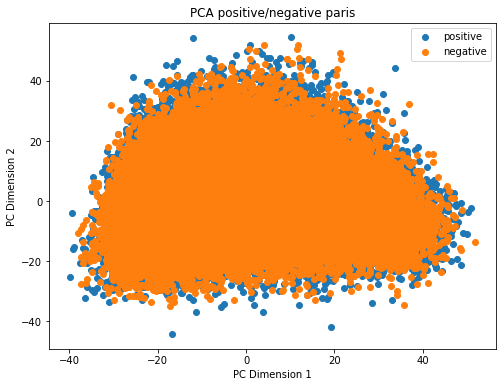

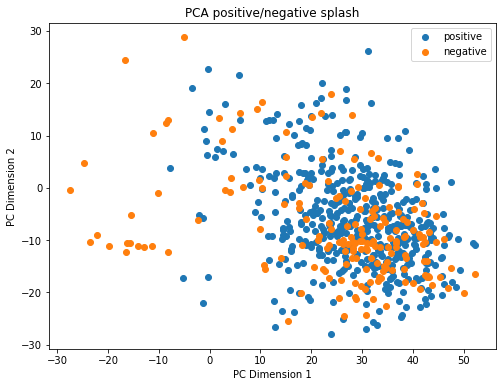

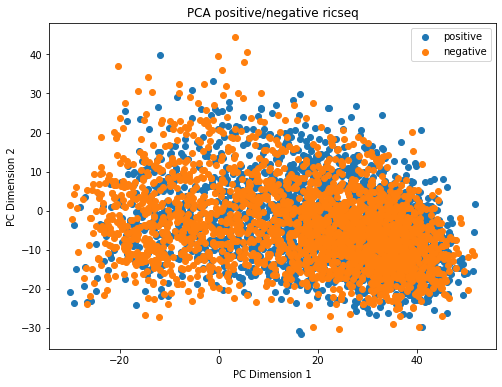

In [16]:
pos_df = final_df_posneg[final_df_posneg.how == 'positive']
neg_df = final_df_posneg[final_df_posneg.how == 'negative']

for subset in ['paris', 'splash', 'ricseq']:
    plt.scatter(pos_df[pos_df.dataset == subset][f'PC1'], pos_df[pos_df.dataset == subset][f'PC2'], label='positive')
    plt.scatter(neg_df[neg_df.dataset == subset][f'PC1'], neg_df[neg_df.dataset == subset][f'PC2'], label='negative')
    plt.title(f'PCA positive/negative {subset}')
    plt.xlabel(f"PC Dimension 1")
    plt.ylabel(f"PC Dimension 2")
    plt.legend()
    plt.show()

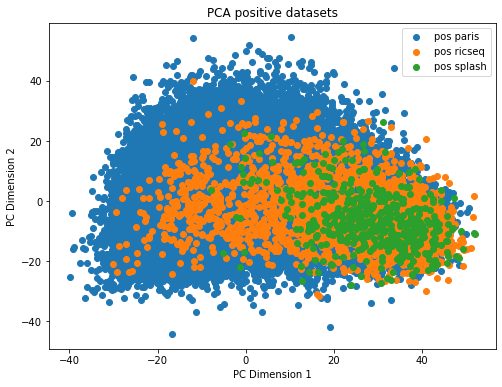

In [17]:
plt.scatter(pos_df[pos_df.dataset == 'paris'][f'PC1'], pos_df[pos_df.dataset == 'paris'][f'PC2'], label='pos paris')
plt.scatter(pos_df[pos_df.dataset == 'ricseq'][f'PC1'], pos_df[pos_df.dataset == 'ricseq'][f'PC2'], label='pos ricseq')
plt.scatter(pos_df[pos_df.dataset == 'splash'][f'PC1'], pos_df[pos_df.dataset == 'splash'][f'PC2'], label='pos splash')


plt.title('PCA positive datasets')
plt.xlabel(f"PC Dimension 1")
plt.ylabel(f"PC Dimension 2")
plt.legend()
plt.show()

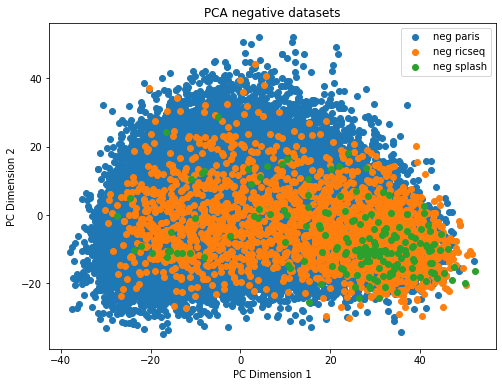

In [18]:
plt.scatter(neg_df[neg_df.dataset == 'paris'][f'PC1'], neg_df[neg_df.dataset == 'paris'][f'PC2'], label='neg paris')
plt.scatter(neg_df[neg_df.dataset == 'ricseq'][f'PC1'], neg_df[neg_df.dataset == 'ricseq'][f'PC2'], label='neg ricseq')
plt.scatter(neg_df[neg_df.dataset == 'splash'][f'PC1'], neg_df[neg_df.dataset == 'splash'][f'PC2'], label='neg splash')


plt.title('PCA negative datasets')
plt.xlabel(f"PC Dimension 1")
plt.ylabel(f"PC Dimension 2")
plt.legend()
plt.show()

### Results repeats

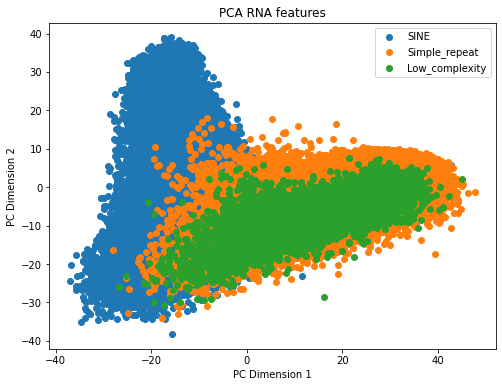

In [86]:
features_to_plot = ['SINE', 'Simple_repeat', 'Low_complexity']#, 'SINE']

for f in list(features_to_plot):
    plt.scatter(repeats_df[repeats_df.feature == f][f'PC1'], repeats_df[repeats_df.feature == f][f'PC2'], label=f)

plt.title('PCA RNA features')
plt.xlabel(f"PC Dimension 1")
plt.ylabel(f"PC Dimension 2")
plt.legend()
plt.show()

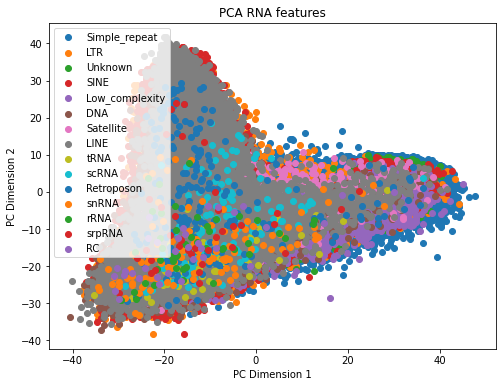

In [83]:
for f in list(repeats_df.feature.unique()):
    plt.scatter(repeats_df[repeats_df.feature == f][f'PC1'], repeats_df[repeats_df.feature == f][f'PC2'], label=f)

plt.title('PCA RNA features')
plt.xlabel(f"PC Dimension 1")
plt.ylabel(f"PC Dimension 2")
plt.legend()
plt.show()

In [75]:
df_groupby = df.groupby(['gene_id', 'feature']).mean().reset_index()[['gene_id', 'feature', 'interacting', 'len_feature', 'length']]

In [76]:
df_groupby['prob_to_sample_f'] = df_groupby['len_feature']/df_groupby['length'] *100

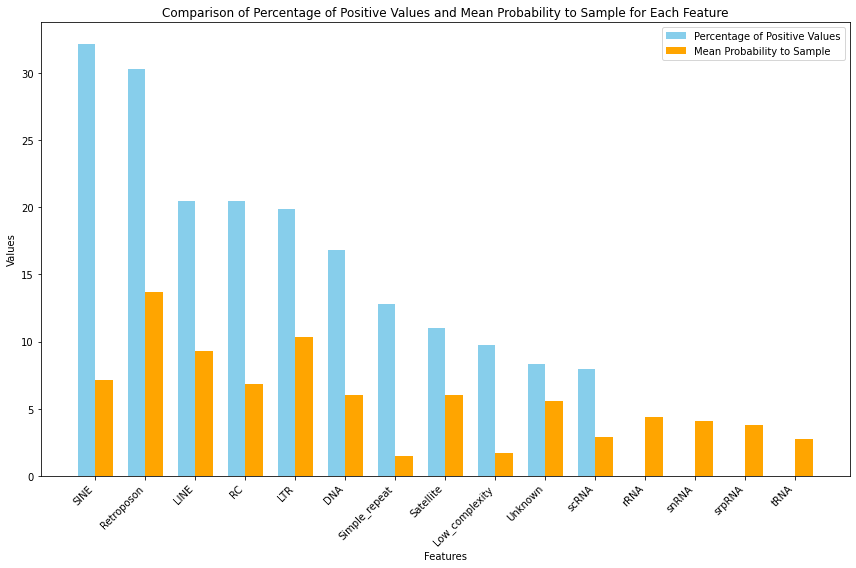

In [77]:
perc_positives = []
features = []
mean_prob_to_sample_f = []

# Iterate through unique features
for f in list(df_groupby.feature.unique()):
    features.append(f)
    df_feature = df_groupby[df_groupby.feature == f]
    p_pos = df_feature.interacting.sum()/df_feature.shape[0] * 100
    perc_positives.append(p_pos)
    mean_prob_to_sample_f.append(df_feature.prob_to_sample_f.mean())

sorted_data = sorted(zip(perc_positives, mean_prob_to_sample_f, features), reverse=True)
perc_positives, mean_prob_to_sample_f, features = zip(*sorted_data)

# ---- BAR CHART ----

# Adjusted bar width and positioning
bar_width = 0.35  # Width of each bar
index = np.arange(len(features))  # X-axis positions for the bars

# Plotting the double bar chart
fig, ax = plt.subplots(figsize=(12, 8))

bar1 = ax.bar(index - bar_width/2, perc_positives, bar_width, label='Percentage of Positive Values', color='skyblue')
bar2 = ax.bar(index + bar_width/2, mean_prob_to_sample_f, bar_width, label='Mean Probability to Sample', color='orange')

# Customize the plot
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Comparison of Percentage of Positive Values and Mean Probability to Sample for Each Feature')
ax.set_xticks(index)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

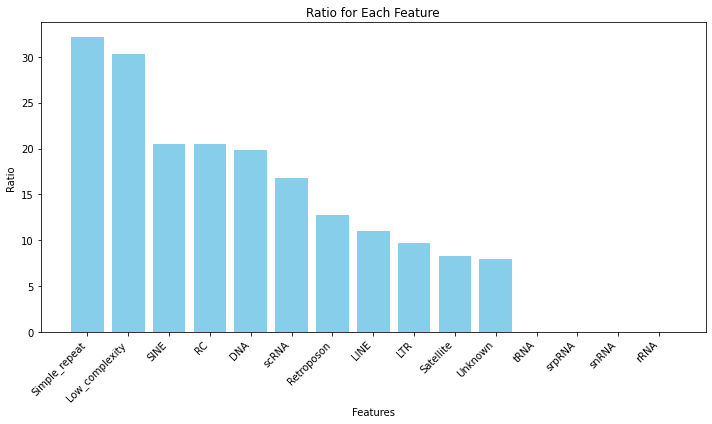

In [78]:
ratio = list(np.array(perc_positives)/np.array(mean_prob_to_sample_f))

sorted_data = sorted(zip(ratio, features), reverse=True)
ratio, features = zip(*sorted_data)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(features, perc_positives, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Ratio ')
plt.title('Ratio for Each Feature')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

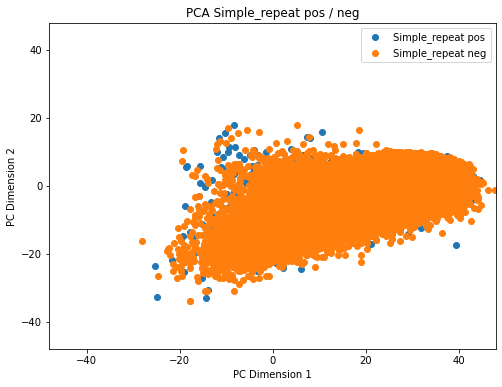

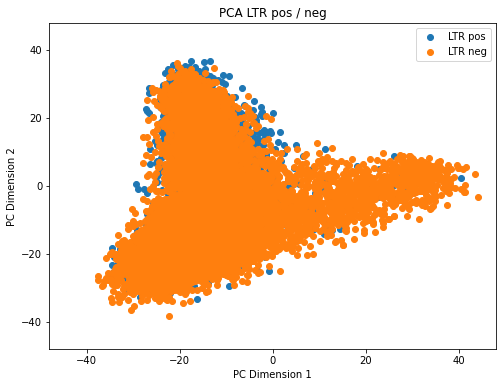

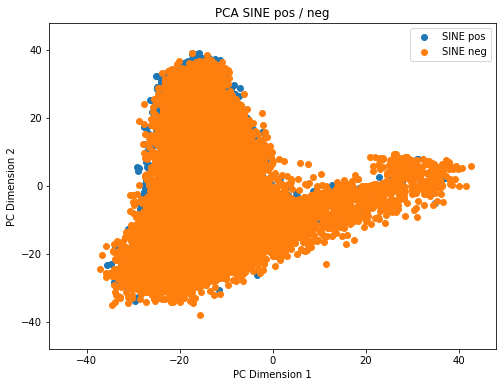

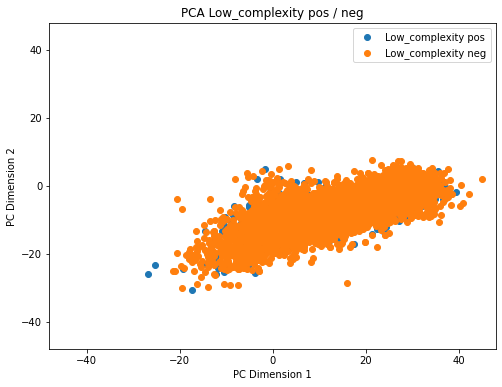

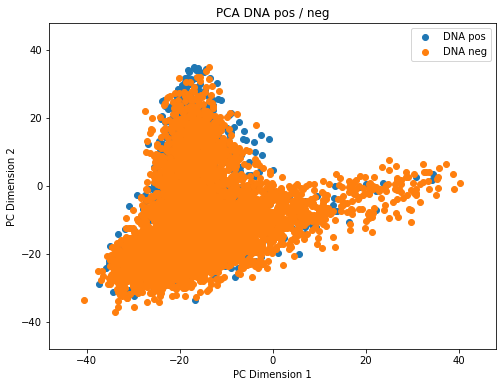

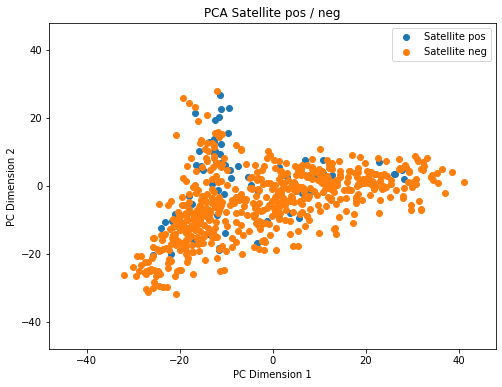

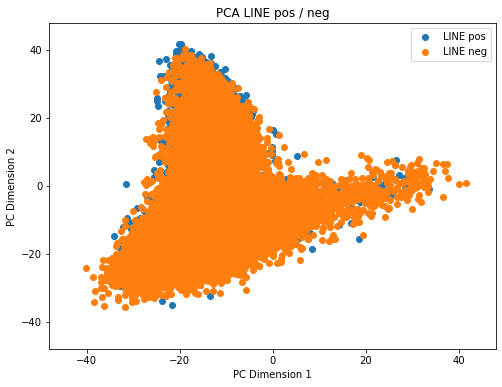

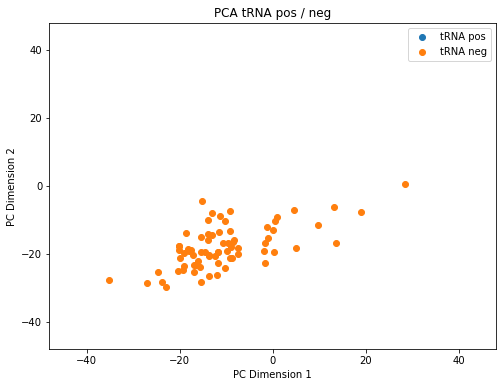

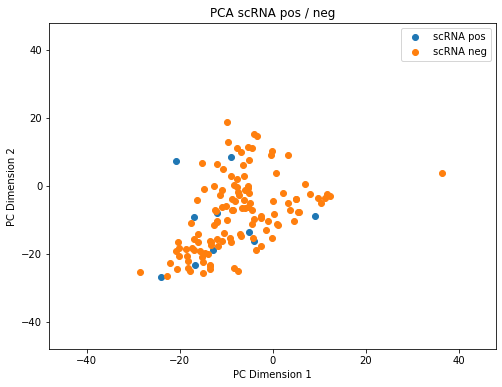

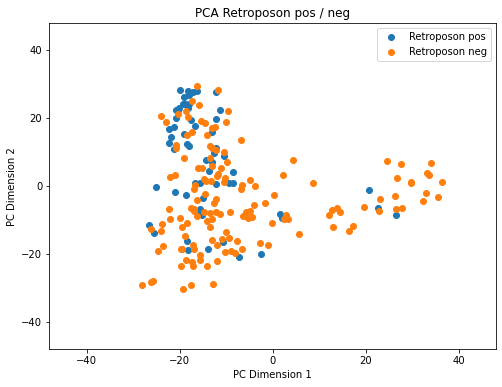

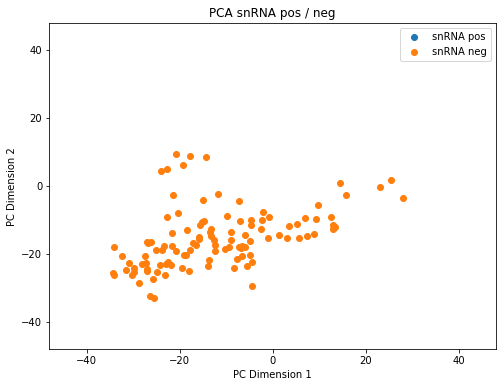

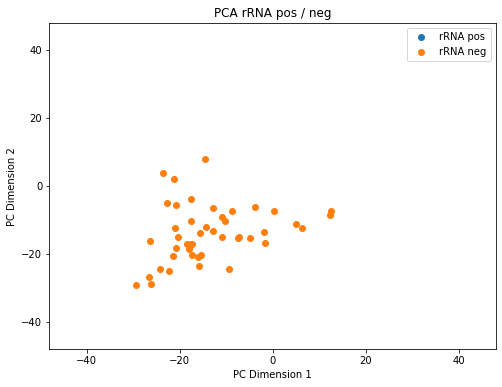

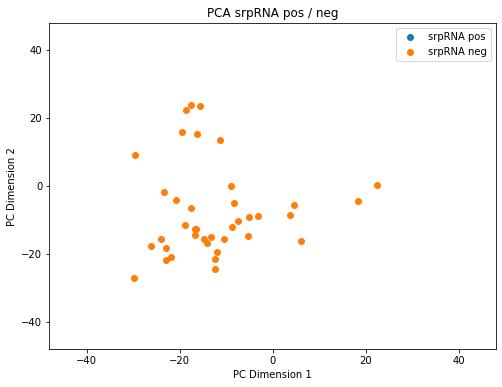

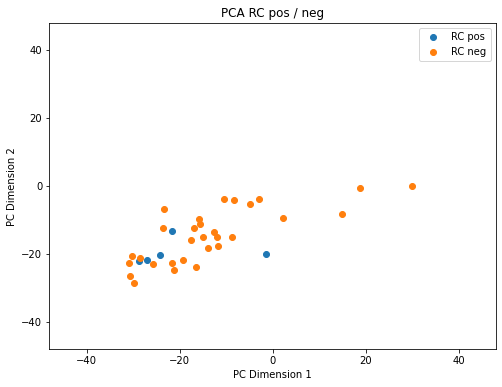

In [79]:
repeats_df_pos = repeats_df[repeats_df['interacting'] == True]
repeats_df_neg = repeats_df[repeats_df['interacting'] == False]
for f in list(repeats_df.feature.unique()):
    plt.scatter(repeats_df_pos[repeats_df_pos.feature == f][f'PC1'], repeats_df_pos[repeats_df_pos.feature == f][f'PC2'], label=f+' pos')
    plt.scatter(repeats_df_neg[repeats_df_neg.feature == f][f'PC1'], repeats_df_neg[repeats_df_neg.feature == f][f'PC2'], label=f+' neg')
    plt.xlim(-48, 48)
    plt.ylim(-48, 48)
    plt.title(f'PCA {f} pos / neg')
    plt.xlabel(f"PC Dimension 1")
    plt.ylabel(f"PC Dimension 2")
    plt.legend()
    plt.show()

# Classifier

In [25]:
random_seed = 23

In [27]:
# X = posneg_features
# y = pd.Series([0 if i == 'negative' else 1 for i in final_df_posneg['how']])

# # subsample training data
# train_x, test_x, train_y, test_y = train_test_split(
#     X, y, train_size=0.8, stratify=y, random_state = random_seed
# )

In [26]:
ONLY_NEGWIND_FULL = False

if ONLY_NEGWIND_FULL:
    train_condition = (df_posneg.dataset == 'paris') & (df_posneg.neg_window_is_reduced == False)
    test_condition = ( (df_posneg.dataset == 'ricseq')|(df_posneg.dataset == 'splash') ) & (df_posneg.neg_window_is_reduced == False)
    
else:
    train_condition = (df_posneg.dataset == 'paris')
    test_condition = (df_posneg.dataset == 'ricseq')|(df_posneg.dataset == 'splash')
    
train_x = posneg_features[train_condition]
train_y = pd.Series([0 if i == 'negative' else 1 for i in df_posneg[train_condition]['how']])
                    
test_x = posneg_features[test_condition]
test_y = pd.Series([0 if i == 'negative' else 1 for i in df_posneg[test_condition]['how']])

In [27]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((80569, 2560), (80569,), (5552, 2560), (5552,))

In [28]:
np.unique(train_y, return_counts = True)

(array([0, 1]), array([39820, 40749]))

In [29]:
np.unique(test_y, return_counts = True)

(array([0, 1]), array([2601, 2951]))

In [58]:
#Train and save or load the model
filename_scaler = os.path.join(emb_dir, 'scaler.joblib')
filename = os.path.join(emb_dir, 'rf_model_easy3.joblib') #os.path.join(emb_dir, 'rf_model.joblib')
if os.path.exists(filename):
    clf = joblib.load(filename)
    scaler = joblib.load(filename_scaler)
    train_x_scaled = scaler.transform(train_x)
    test_x_scaled = scaler.transform(test_x)
else:
    scaler = StandardScaler()
    train_x_scaled = scaler.fit_transform(train_x)
    test_x_scaled = scaler.transform(test_x)
    joblib.dump(scaler, filename_scaler)
    
    #logistic
    filename = os.path.join(emb_dir, 'logistic_model.joblib')
    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_x_scaled, train_y)
    joblib.dump(clf, filename)
    
    #random forest
    filename = os.path.join(emb_dir, 'rf_model.joblib')
    clf = RandomForestClassifier(n_estimators=100, random_state=random_seed) 
    clf.fit(train_x_scaled, train_y)
    joblib.dump(clf, filename)
    
    #random forest easy
    filename = os.path.join(emb_dir, 'rf_model_easy.joblib')
    clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=random_seed) 
    clf.fit(train_x_scaled, train_y)
    joblib.dump(clf, filename)
    
    #random forest easy2
    filename = os.path.join(emb_dir, 'rf_model_easy2.joblib')
    clf = RandomForestClassifier(n_estimators=30, max_depth=8, random_state=random_seed) 
    clf.fit(train_x_scaled, train_y)
    joblib.dump(clf, filename)
    
    #random forest easy3
    filename = os.path.join(emb_dir, 'rf_model_easy3.joblib')
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=random_seed) 
    clf.fit(train_x_scaled, train_y)
    joblib.dump(clf, filename)

In [59]:
# Predicting 
predictions_train = clf.predict(train_x_scaled)
predictions_test = clf.predict(test_x_scaled)

In [60]:
np.unique(predictions_test, return_counts= True)

(array([0, 1]), array([1621, 3931]))

In [61]:
# Evaluating the model
accuracy_train = clf.score(train_x_scaled, train_y)
accuracy_test = clf.score(test_x_scaled, test_y)
print(f"Accuracy of the model on training set: {np.round(accuracy_train, 3)}")
print(f"Accuracy of the model on test set: {np.round(accuracy_test, 3)}")

Accuracy of the model on training set: 0.591
Accuracy of the model on test set: 0.578


### Explore test results

In [62]:
test_results = pd.concat([df_posneg[test_condition].reset_index(), pd.Series(predictions_test)], axis = 1).rename({0:'prediction'}, axis = 1)

In [63]:
test_results['interacting'] = False
test_results.loc[ test_results['how'] == 'positive', 'interacting'] = True
test_results['label'] = test_results.interacting.astype(int)
test_results['probability'] = pd.Series(clf.predict_proba(test_x_scaled)[:, 1])

In [64]:
ricseq = test_results[test_results['dataset'] == 'ricseq']
splash = test_results[test_results['dataset'] == 'splash']

print(f"Accuracy of the model on ricseq set: {np.round((ricseq.label == ricseq.prediction).sum()/ricseq.shape[0], 3)}")
print(f"Accuracy of the model on splash set: {np.round((splash.label == splash.prediction).sum()/splash.shape[0], 3)}")

ricseq = ricseq[ricseq.neg_window_is_reduced == False]
splash = splash[splash.neg_window_is_reduced == False]

print(f"Accuracy of the model on not biased ricseq set: {np.round((ricseq.label == ricseq.prediction).sum()/ricseq.shape[0], 3)}")
print(f"Accuracy of the model on not biased splash set: {np.round((splash.label == splash.prediction).sum()/splash.shape[0], 3)}")

Accuracy of the model on ricseq set: 0.56
Accuracy of the model on splash set: 0.713
Accuracy of the model on not biased ricseq set: 0.531
Accuracy of the model on not biased splash set: 0.667


# Explained Variance Ratio

##### Pos/neg

2 variables explain the 6.58% of the variance


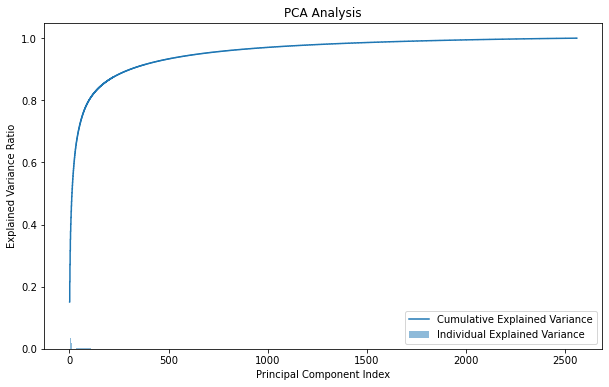

In [57]:
n_feat = posneg_features.shape[1]

# Step 1: Initialize PCA
pca = PCA(n_components=n_feat)

# Step 2: Fit and transform your data
pca_result = pca.fit_transform(posneg_features)

# Step 3: Calculate explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print(f'2 variables explain the {np.round(explained_variance_ratio[1] * 100, 2)}% of the variance')

# Step 5: Plotting
plt.figure(figsize=(10, 6))

# Plotting individual explained variance as a histogram
plt.bar(range(1, n_feat+1), explained_variance_ratio, label='Individual Explained Variance', alpha=0.5)

# Plotting cumulative explained variance as a step function
plt.step(range(1, n_feat+1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')

# Adding labels and title
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Analysis')
plt.legend()

# Show the plot
plt.show()

##### Repeats

2 variables explain the 9.09% of the variance


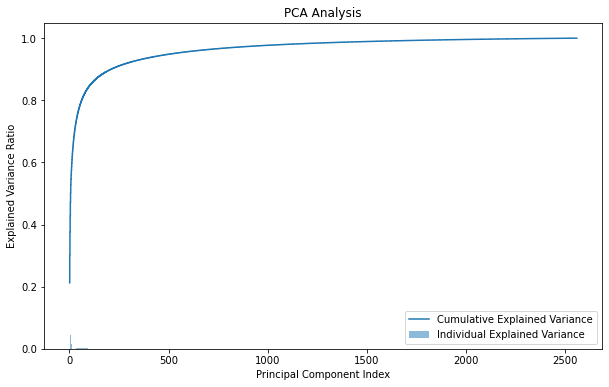

In [31]:
n_feat = numerical_features_scaled.shape[1]

# Step 1: Initialize PCA
pca = PCA(n_components=n_feat)

# Step 2: Fit and transform your data
pca_result = pca.fit_transform(df_features)

# Step 3: Calculate explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print(f'2 variables explain the {np.round(explained_variance_ratio[1] * 100, 2)}% of the variance')

# Step 5: Plotting
plt.figure(figsize=(10, 6))

# Plotting individual explained variance as a histogram
plt.bar(range(1, n_feat+1), explained_variance_ratio, label='Individual Explained Variance', alpha=0.5)

# Plotting cumulative explained variance as a step function
plt.step(range(1, n_feat+1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')

# Adding labels and title
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Analysis')
plt.legend()

# Show the plot
plt.show()